####  Predict School Closure in NCES-CCD Data:

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.optimize import minimize

from sklearn.preprocessing import Imputer, normalize
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [2]:
#Read In Data
df=pd.read_pickle("data/school_closure_clean.pkl")

df.set_index("NCESSCH", inplace=True)
df.drop(["LEAID","LEANM","SCHNAM","LEVEL","LSTATE","TYPE","STATUS","ULOCAL","FTE","TITLEI","STITLI","TOTFRL","WHITE",\
         "TOTETH","STNAM","MATH_PROF","ELA_PROF","MATH_PROF_CLN","ELA_PROF_CLN","CLOSED10","CLOSED11",\
        "CLOSED12","CLOSED13","CLOSED14","in_ranks"], axis=1, inplace=True)

print df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90713 entries, 10000201876 to 780003000034
Data columns (total 31 columns):
MAGNET              90713 non-null float64
CHARTR              90713 non-null float64
SHARED              90713 non-null float64
MEMBER              88469 non-null float64
NEW_ENGLAND         90713 non-null float64
MID_ATLANTIC        90713 non-null float64
EAST_NORTH_CENTL    90713 non-null float64
WEST_NORTH_CENTL    90713 non-null float64
SOUTH_ATLANTIC      90713 non-null float64
EAST_SOUTH_CENTL    90713 non-null float64
WEST_SOUTH_CENTL    90713 non-null float64
MOUNTAIN            90713 non-null float64
PACIFIC             90713 non-null float64
CITY                90439 non-null float64
SUBURB              90439 non-null float64
TOWN                90439 non-null float64
RURAL               90439 non-null float64
ELEM                90713 non-null int64
MIDDLE              90713 non-null int64
HIGH                90713 non-null int64
OTHER               

In [3]:
#Deal with Feature Missing Data via Casewise Deletion or Means Imputation
def means_impute(df):
    imputed=Imputer().fit_transform(df[df.columns])
    new_df=pd.DataFrame(imputed, columns=[df.columns])
    
    return new_df

def casewise_delete(df):
    new_df=df.copy()
    
    for col in df.columns:
        new_df=new_df[new_df[col].notnull()]
        
    return new_df

clean=means_impute(df)
print clean.shape

(90713, 31)


##### Test Classifiers on All Data

In [4]:
#Train/ Test Split
train, test = train_test_split(clean, test_size=0.3, random_state=4444)

print type(train), type(test)
print train.shape, test.shape

print train.columns

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
(63499, 31) (27214, 31)
Index([u'MAGNET', u'CHARTR', u'SHARED', u'MEMBER', u'NEW_ENGLAND',
       u'MID_ATLANTIC', u'EAST_NORTH_CENTL', u'WEST_NORTH_CENTL',
       u'SOUTH_ATLANTIC', u'EAST_SOUTH_CENTL', u'WEST_SOUTH_CENTL',
       u'MOUNTAIN', u'PACIFIC', u'CITY', u'SUBURB', u'TOWN', u'RURAL', u'ELEM',
       u'MIDDLE', u'HIGH', u'OTHER', u'T1_ALL', u'T1_SOME', u'T1_NONE',
       u'PCT_MINORITY', u'PCT_FRL', u'ST_RATIO', u'MATH_RANK', u'ELA_RANK',
       u'intercept', u'CLOSED'],
      dtype='object')


In [5]:
##Write Functions
##Function to Upsample and/ or Downsample
def sampler(df, r, upsample, features, label):
    nlabel = df[label].value_counts()[1]
    nsamp = int(round(nlabel*r))
    
    if upsample==True:
        df_1 = df[df[label]==1].sample(n=nsamp, replace=True).copy()
        df_0 = df[df[label]==0].sample(n=nsamp, replace=True).copy()
    else:
        df_1 = df[df[label]==1].copy()
        df_0 = df[df[label]==0].sample(n=nsamp).copy()
        
    return pd.concat([df_1, df_0], axis=0)


def plot_PR_curve_noadj(classname, classifier, features, label):
    train_X=train[features]
    train_y=train[label]
    
    test_X=test[features]
    test_y=test[label]
    
    model=classifier.fit(train_X, train_y)
    
    pr1 = [x[1] for x in model.predict_proba(test_X)]
    print classname, np.min(pr1), np.median(pr1), np.max(pr1)
    
    prec, recall, t = precision_recall_curve(test_y, pr1)
    plt.plot(prec, recall, label=classname)
    

def plot_PR_curve(classname, classifier, r, upsample, features, label):
    strain=sampler(train, r, upsample, features, label)
    print strain.CLOSED.value_counts()
    
    strain_X=strain[features]
    strain_y=strain[label]
    
    test_X=test[features]
    test_y=test[label]
    
    model=classifier.fit(strain_X, strain_y)

    pr1 = [x[1] for x in model.predict_proba(test_X)]
    print classname, np.min(pr1), np.median(pr1), np.max(pr1)
    
    prec, recall, t = precision_recall_curve(test_y, pr1)
    plt.plot(prec, recall, label=classname)

#### (1) Straight Up (Multiple Classifier)

Bagging Classifier 0.0 0.026 0.977354212454
Random Forest 0.0 0.026 0.965152614379
Extra Trees Classifier 0.0 0.022 1.0
Bernoulli Naive Bayes 0.0102835041806 0.0529637094153 0.657933982693


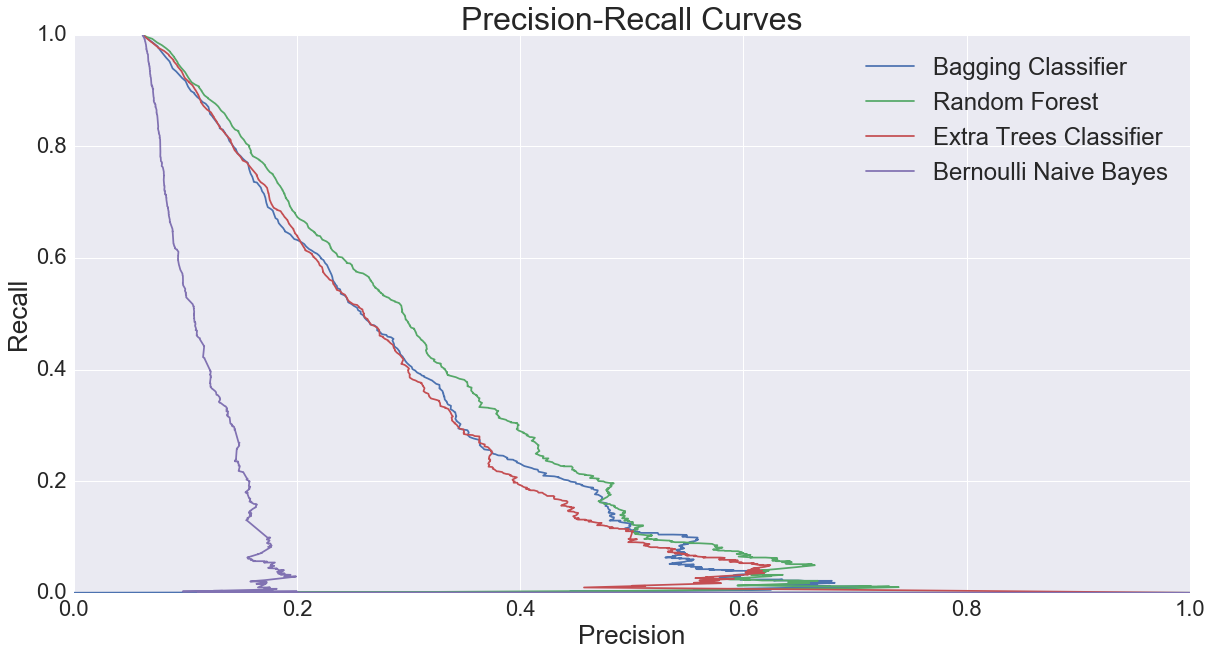

In [6]:
f = clean.columns[:-2].tolist()
l = clean.columns[-1]

plt.figure(figsize=(20,10))
plot_PR_curve_noadj("Bagging Classifier", BaggingClassifier(n_estimators=500), f, l)
plot_PR_curve_noadj("Random Forest", RandomForestClassifier(n_estimators=500), f, l)
plot_PR_curve_noadj("Extra Trees Classifier", ExtraTreesClassifier(n_estimators=500), f, l)
plot_PR_curve_noadj("Bernoulli Naive Bayes", BernoulliNB(), f, l)

plt.legend(loc="best", fontsize=24)
plt.xlabel("Precision", fontsize=26)
plt.ylabel("Recall", fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Precision-Recall Curves", fontsize=32)
plt.savefig("graphics/Precision-Recall-Overall.png")

#### (2) With 1:1 Downsampling (Multiple Classifers)

1    3990
0    3990
Name: CLOSED, dtype: int64
Bagging Classifier 0.0 0.316 1.0
1    3990
0    3990
Name: CLOSED, dtype: int64
Random Forest 0.0 0.319527777778 1.0
1    3990
0    3990
Name: CLOSED, dtype: int64
Extra Trees Classifier 0.0 0.322 1.0
1    3990
0    3990
Name: CLOSED, dtype: int64
Bernoulli Naive Bayes 0.145198023527 0.453170608348 0.965979430312


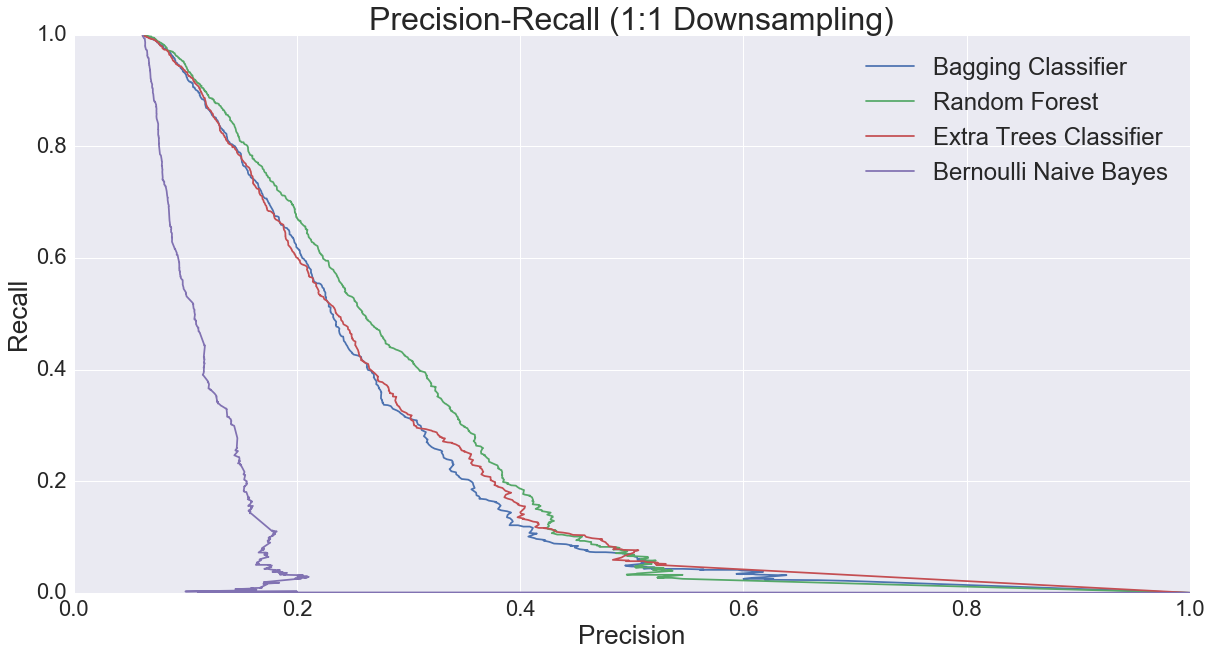

In [7]:
plt.figure(figsize=(20,10))
plot_PR_curve("Bagging Classifier", BaggingClassifier(n_estimators=500), 1.0, False, f, l)
plot_PR_curve("Random Forest", RandomForestClassifier(n_estimators=500), 1.0, False, f, l)
plot_PR_curve("Extra Trees Classifier", ExtraTreesClassifier(n_estimators=500), 1.0, False, f, l)
plot_PR_curve("Bernoulli Naive Bayes", BernoulliNB(), 1.0, False, f, l)

plt.legend(loc="best", fontsize=24)
plt.xlabel("Precision", fontsize=26)
plt.ylabel("Recall", fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Precision-Recall (1:1 Downsampling)", fontsize=32)
plt.savefig("graphics/precision-recall-1to1downsample.png")

#### (3) Random Forest Varying  Upsampling/ Downsampling

0    39900
1     3990
Name: CLOSED, dtype: int64
10:1 0.0 0.042 0.998285714286
0    19950
1     3990
Name: CLOSED, dtype: int64
5:1 0.0 0.084 1.0
0    7980
1    3990
Name: CLOSED, dtype: int64
2:1 0.0 0.192 1.0
1    3990
0    3990
Name: CLOSED, dtype: int64
1:1 0.0 0.322 1.0
1    39900
0    39900
Name: CLOSED, dtype: int64
10:10 0.0 0.0718250319285 1.0
1    19950
0    19950
Name: CLOSED, dtype: int64
5:5 0.0 0.126 1.0
1    7980
0    7980
Name: CLOSED, dtype: int64
2:2 0.0 0.212 1.0
1    3990
0    3990
Name: CLOSED, dtype: int64
1:1 0.0 0.262 1.0


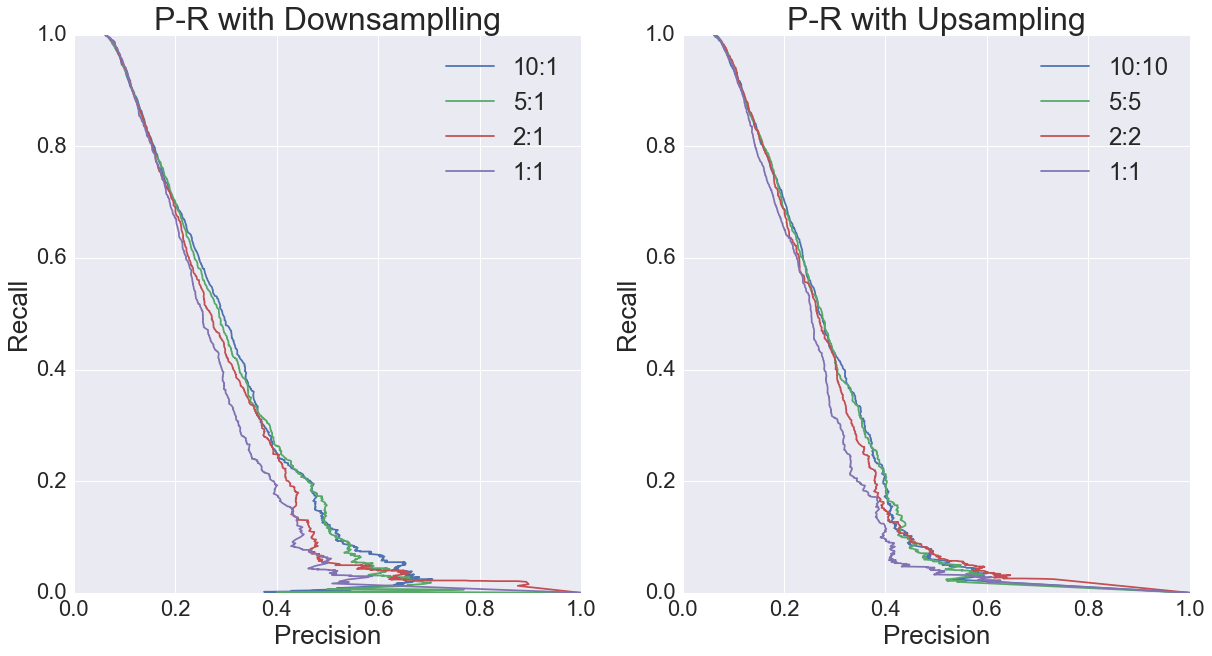

In [8]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plot_PR_curve("10:1", RandomForestClassifier(n_estimators=500), 10.0, False, f, l)
plot_PR_curve("5:1", RandomForestClassifier(n_estimators=500), 5.0, False, f, l)
plot_PR_curve("2:1", RandomForestClassifier(n_estimators=500), 2.0, False, f, l)
plot_PR_curve("1:1", RandomForestClassifier(n_estimators=500), 1.0, False, f, l)

plt.legend(loc="best", fontsize=24)
plt.xlabel("Precision", fontsize=26)
plt.ylabel("Recall", fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("P-R with Downsamplling", fontsize=32)

plt.subplot(1,2,2)
plot_PR_curve("10:10", RandomForestClassifier(n_estimators=500), 10.0, True, f, l)
plot_PR_curve("5:5", RandomForestClassifier(n_estimators=500), 5.0, True, f, l)
plot_PR_curve("2:2", RandomForestClassifier(n_estimators=500), 2.0, True, f, l)
plot_PR_curve("1:1", RandomForestClassifier(n_estimators=500), 1.0, True, f, l)

plt.legend(loc="best", fontsize=24)
plt.xlabel("Precision", fontsize=26)
plt.ylabel("Recall", fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("P-R with Upsampling", fontsize=32)

plt.savefig("graphics/precision-recall-up-down-sample.png")